# Run Settings 

In [75]:
%run run_model.py

# Encoder-Decoder - 3000 samples - softmax 

## Settings 

In [76]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 3000  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/corpus4938.csv'

train_file, test_file = load_train_test(corpus = complete_corpus_path, num_samples=num_samples, test_size=test_size)

## Vectorize Data

In [41]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# Dictionary of tokens
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 3000
Number of unique input tokens: 26
Number of unique output tokens: 32
Max sequence length for inputs: 15
Max sequence length for outputs: 16


# Model

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [26]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model5.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Run Training 

In [37]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 2400 samples, validate on 600 samples
Epoch 1/100
Epoch 00001: val_loss improved from 1.31209 to 1.12663, saving model to Models/model5.h5


/Users/Beatriz/Dropbox/Linguística/algoritmos/principal/WickelfeaturesProject/mestrado/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 - 11s - loss: 1.1187 - acc: 0.1757 - val_loss: 1.1266 - val_acc: 0.2010
Epoch 2/100
Epoch 00002: val_loss improved from 1.12663 to 1.04979, saving model to Models/model5.h5
 - 10s - loss: 0.9993 - acc: 0.2036 - val_loss: 1.0498 - val_acc: 0.2106
Epoch 3/100
Epoch 00003: val_loss improved from 1.04979 to 0.94620, saving model to Models/model5.h5
 - 11s - loss: 0.9057 - acc: 0.2251 - val_loss: 0.9462 - val_acc: 0.2351
Epoch 4/100
Epoch 00004: val_loss did not improve
 - 10s - loss: 0.8421 - acc: 0.2402 - val_loss: 0.9709 - val_acc: 0.2196
Epoch 5/100
Epoch 00005: val_loss improved from 0.94620 to 0.88096, saving model to Models/model5.h5
 - 10s - loss: 0.7868 - acc: 0.2532 - val_loss: 0.8810 - val_acc: 0.2502
Epoch 6/100
Epoch 00006: val_loss improved from 0.88096 to 0.80939, saving model to Models/model5.h5
 - 10s - loss: 0.7444 - acc: 0.2634 - val_loss: 0.8094 - val_acc: 0.2680
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 10s - loss: 0.6980 - acc: 0.2766 - val_loss: 0.8323 - v

## Save Results 

In [50]:
with open('Files/train_history_model5', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [38]:
# Save Weights
save_path = '3000-softmax-no-dropout.h5'
model.save_weights('Models/' + save_path)

In [39]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


## Summary and Plots 

|     Model Name     | Test File     | Best Epoch Score | val_acc | val_loss | loss | acc    | Time|
|:------------------:|---------------|-----------------:|---------|----------|------|--------|-----|
| Model5.h5    | Corpus/test100verbs.csv      |   54    |  0.423  |  0.340   | 0.030|0.4789  |15 min|

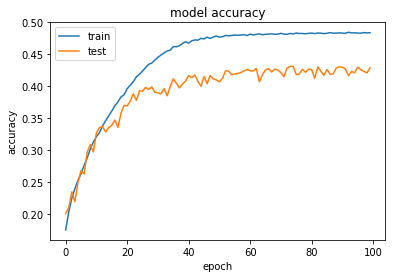

In [51]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

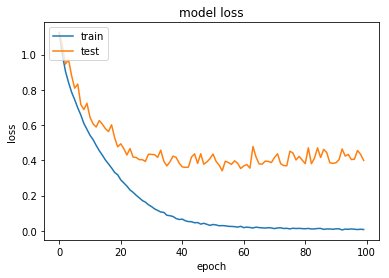

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Inference Mode 

In [47]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('Models/3000-softmax-no-dropout.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

## Test it on training set 

In [45]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [62]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

In [63]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return test

In [66]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return df_test

In [48]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estou

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero

-


In [80]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

## Test it on the Testing set 

In [251]:
df_Test = load_test(test_file)

In [252]:
df_Test['encoding'] = df_Test.iloc[:60].infinitivo.apply(encode_sequence).apply(decode_sequence)

In [213]:
df_Test.head(60).values

array([['deformar', 'deformo', 'deforrio\n'],
       ['inferiorizar', 'inferiorizo', 'infirro\n'],
       ['ticar', 'tico', 'tico\n'],
       ['traquear', 'traqueio', 'tranjo\n'],
       ['desencantar', 'desencanto', 'desencanto\n'],
       ['excetuar', 'excetuo', 'executo\n'],
       ['acarear', 'acareio', 'acarelo\n'],
       ['chispar', 'chispo', 'chiso\n'],
       ['drenar', 'dreno', 'redeno\n'],
       ['encarcerar', 'encarcero', 'encarero\n'],
       ['fustigar', 'fustigo', 'fustio\n'],
       ['ilidir', 'ilido', 'ilido\n'],
       ['maximizar', 'maximizo', 'mamigizo\n'],
       ['quantificar', 'quantifico', 'quantifico\n'],
       ['reconquistar', 'reconquisto', 'reconsilio\n'],
       ['talhar', 'talho', 'talho\n'],
       ['tralhar', 'tralho', 'tralho\n'],
       ['verear', 'vereio', 'verezo\n'],
       ['alarmar', 'alarmo', 'alarro\n'],
       ['dissimular', 'dissimulo', 'dissumplido\n'],
       ['ortografar', 'ortografo', 'ootrego\n'],
       ['regatear', 'regateio', 'regato

In [253]:
def test_accuracy(df, len_test):
    df_Test['encoding'] = df_Test['encoding'].apply(lambda x: str(x)[:-1])

    df_Test['conjugado'] = df_Test['conjugado'].apply(lambda x: str(x))

    df = df_Test

    matches = df[df['encoding'] == df['conjugado']]

    return float(len(matches))/len_test 

In [254]:
test_accuracy(df_Test, 60)

0.38333333333333336